In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

/Users/gwhilton/miniforge3/envs/rl2/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gwhilton/miniforge3/envs/rl2/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Train Loss: 0.5424, Val Loss: 0.6268, Val Accuracy: 0.6800
Epoch 2/50, Train Loss: 0.1407, Val Loss: 0.4926, Val Accuracy: 0.8400
Epoch 3/50, Train Loss: 0.0543, Val Loss: 0.5380, Val Accuracy: 0.7600
Epoch 4/50, Train Loss: 0.0235, Val Loss: 0.5592, Val Accuracy: 0.8000
Epoch 5/50, Train Loss: 0.0089, Val Loss: 0.5459, Val Accuracy: 0.8000
Epoch 6/50, Train Loss: 0.0089, Val Loss: 0.6189, Val Accuracy: 0.7600
Epoch 7/50, Train Loss: 0.0043, Val Loss: 0.7815, Val Accuracy: 0.7600
Early stopping at epoch 7
Test Loss: 1.0937, Test Accuracy: 0.7692


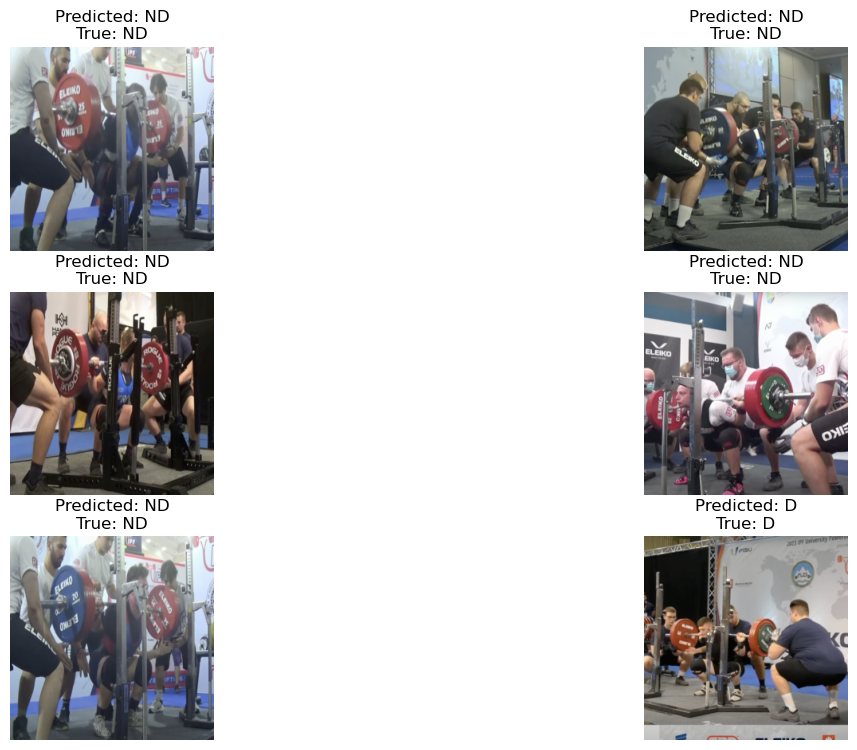

In [27]:

# Parameters
batch_size = 32
learning_rate = 0.0001
num_epochs = 50  # Set to a higher number to give early stopping a chance to stop earlier if needed
num_classes = 2
patience = 5  # Number of epochs with no improvement after which training will be stopped

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset from folders without transformations initially
full_dataset = datasets.ImageFolder(root='./data')

# Calculate split sizes
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Apply different transforms to training, validation, and test datasets
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Modify the final layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Move model to GPU if available
device = torch.device('mps')
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

# Validation function
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    epoch_loss = running_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    return epoch_loss, accuracy, all_preds, all_labels

# Training loop with early stopping
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, _, _ = evaluate(model, val_loader, criterion, device)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_wts = model.state_dict()
    else:
        epochs_no_improve += 1
    
    # Early stopping
    if epochs_no_improve >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

# Load best model weights
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), './model/model.pt')

# Test the model
test_loss, test_accuracy, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Function to display a sample of test images with predictions and true labels
def show_test_predictions(model, loader, device, class_names, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 9))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}')
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    return

# Show a sample of test images with predictions and true labels
class_names = full_dataset.classes  # ['D', 'ND']
show_test_predictions(model, test_loader, device, class_names)
plt.show()

In [28]:
# Function to evaluate the model on a series of images and stop if depth is detected
def evaluate_and_stop_on_depth(model, image_list, transform, device):
    model.eval()
    for idx, image in enumerate(image_list):
        img_tensor = transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = model(img_tensor)
            _, preds = torch.max(outputs, 1)
        
        # Check if the prediction is "D" (assuming label 1 is "D")
        if preds.item() == 0:
            print(f'Depth detected in frame {idx}')
            # Display the image
            plt.imshow(image)
            plt.title(f'Depth detected in frame {idx}')
            plt.axis('off')
            plt.show()
            return preds.cpu().numpy(), idx
    return None, -1

In [29]:
import re
import os
from PIL import Image

# Function to extract the frame number from the filename
def extract_frame_number(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else -1

# Load and sort all images from the 'frames' directory
frames_dir = './frames'
image_paths = [os.path.join(frames_dir, img) for img in os.listdir(frames_dir) if img.endswith(('jpg', 'jpeg', 'png'))]
image_paths.sort(key=lambda x: extract_frame_number(os.path.basename(x)))

# Load images
images = [Image.open(img_path) for img_path in image_paths]

In [30]:
# Evaluate and stop if depth is detected
predictions, frame_idx = evaluate_and_stop_on_depth(model, images, val_test_transform, device)
if frame_idx == -1:
    print('No depth detected in any frame.')
else:
    print(f'Depth detected in frame {frame_idx}')

No depth detected in any frame.
